In [508]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
def plot_outliners(data, column):
    max_charge = data[column].max()
    min_charge = data[column].min()
    print(f"Maior valor de {column}: {max_charge}")
    print(f"Menor valor de {column}: {min_charge}")
    plt.boxplot(data[column])
    plt.title(column.capitalize() + ' Boxplot')
    plt.ylabel('Valores')
    plt.show()

def remove_outliers(df, column):
    Q1, Q3 = np.percentile(df[column], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    print((df[column] >= lower_bound) & (df[column] <= upper_bound))
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    
    print(f"Valores de {column} antes da remoção de outliers: {df[column].shape[0]}")
    print(f"Valores de {column} depois da remoção de outliers: {df[column].shape[0]}")
    print(f"Q1: {Q1}") # separa os 25% menores valores do conjunto de dados.
    print(f"Q3: {Q3}") # separa os 25% maiores valores do conjunto de dados.
    print(f"Limite Inferior: {lower_bound}")
    print(f"Limite Superior: {upper_bound}")
    print("------------------------")
    return df

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


def plot_chart_and_predict(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previsto')
    plt.title('Gráfico de Dispersão: Valores Reais vs Valores Previsto')
    plt.show()

    # Erros
    print("Erro Absoluto Médio (MAE):", mean_absolute_error(y_test, y_pred))
    print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
    print("Raiz do Erro Quadrático Médio (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAPE:", calculate_mape(y_test, y_pred), "%")
    print("R²:", r2_score(y_test, y_pred))


In [510]:
data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo
data.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,yes,16884.92400
1,18,33.770,1,no,1725.55230
2,28,33.000,3,no,4449.46200
3,33,22.705,0,no,21984.47061
4,32,28.880,0,no,3866.85520


In [511]:
data.isnull().sum()

age         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

Maior valor de age: 64
Menor valor de age: 18


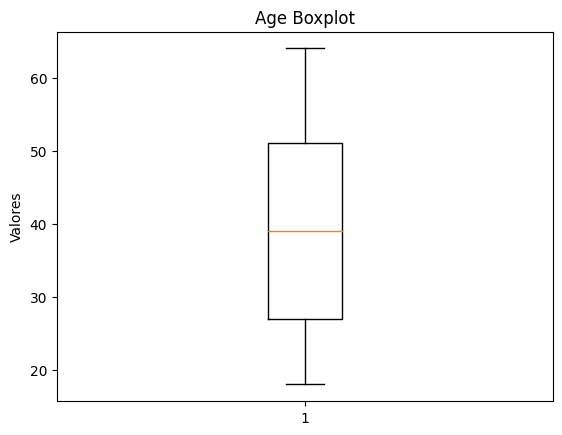

Valores de age antes da remoção de outliers: 1338
Valores de age depois da remoção de outliers: 1338
Q1: 27.0
Q3: 51.0
Limite Inferior: -9.0
Limite Superior: 87.0
------------------------
Maior valor de age: 64
Menor valor de age: 18


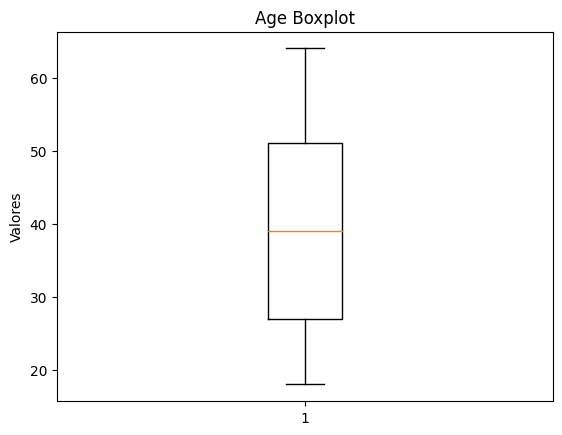

Maior valor de bmi: 53.13
Menor valor de bmi: 15.96


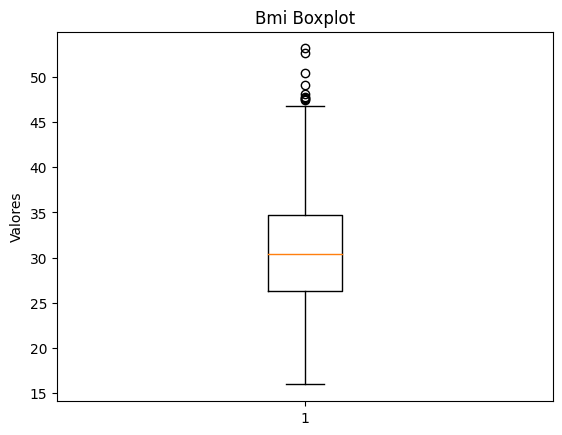

Valores de bmi antes da remoção de outliers: 1329
Valores de bmi depois da remoção de outliers: 1329
Q1: 26.29625
Q3: 34.69375
Limite Inferior: 13.7
Limite Superior: 47.290000000000006
------------------------
Maior valor de bmi: 46.75
Menor valor de bmi: 15.96


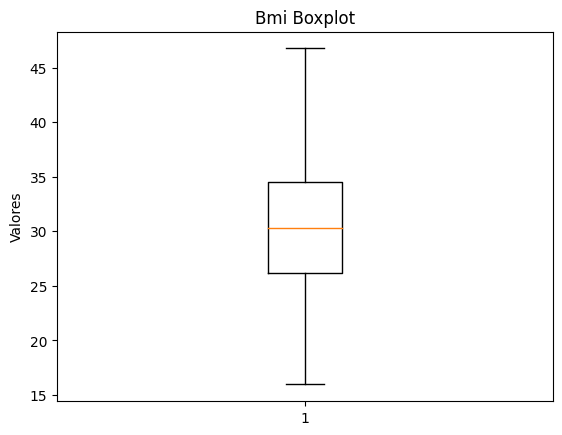

Maior valor de children: 5
Menor valor de children: 0


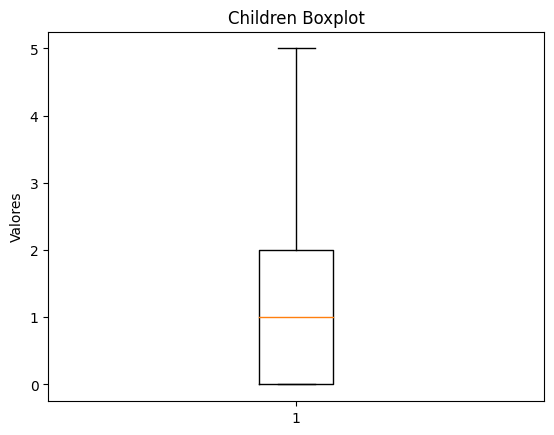

Valores de children antes da remoção de outliers: 1329
Valores de children depois da remoção de outliers: 1329
Q1: 0.0
Q3: 2.0
Limite Inferior: -3.0
Limite Superior: 5.0
------------------------
Maior valor de children: 5
Menor valor de children: 0


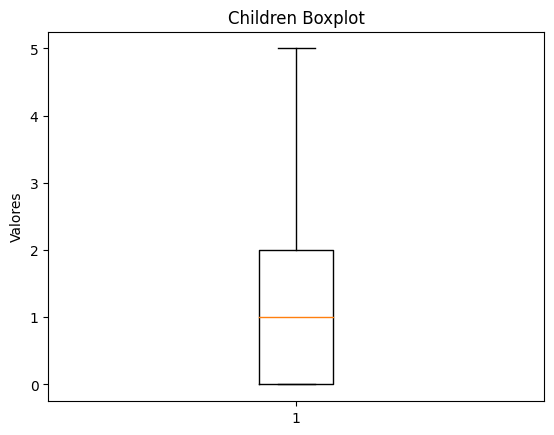

In [512]:
numeric_columns = [ 'age', 'bmi', 'children']
for numeric_collumn in numeric_columns:
    plot_outliners(data , numeric_collumn)
    data = remove_outliers(data, numeric_collumn)
    plot_outliners(data , numeric_collumn)


In [513]:
data.isnull().sum()

age         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

<Axes: >

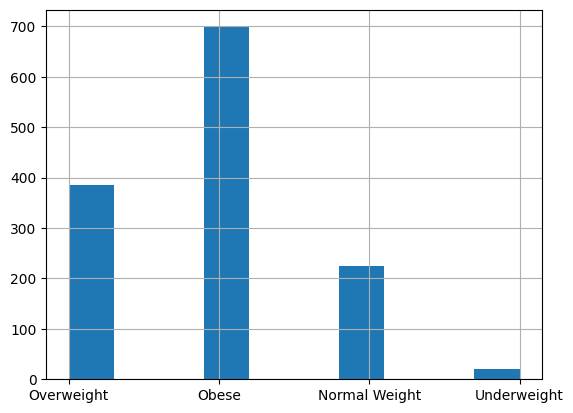

In [514]:
# Aplicando a Obesidade
# https://www.cancer.org/cancer/risk-prevention/diet-physical-activity/body-weight-and-cancer-risk.html
# IMC entre 25,0 e 29,9 Kg/m2: sobrepeso; 
# IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I; 
# IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II; 
# IMC maior do que 40,0 Kg/m2: obesidade grau III.
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"

data["weight_condition"].hist()


In [515]:
# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numeric_columns), #tratando as variáveis numéricas (chamando a pipeline de cima)
    ("cat", OneHotEncoder(drop='first'), categorical_columns), # tratando as variáveis categóricas
])

base_transformed = full_pipeline.fit_transform(data)
base_transformed_df = pd.DataFrame(base_transformed, columns=full_pipeline.get_feature_names_out())
base_transformed_df


,num__age,num__bmi,num__children,cat__smoker_yes,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,-1.438764,-0.445670,-0.907940,1.0,0.0,1.0,0.0
1,-1.509976,0.546267,-0.079764,0.0,1.0,0.0,0.0
2,-0.797855,0.416149,1.576587,0.0,1.0,0.0,0.0
3,-0.441794,-1.323542,-0.907940,0.0,0.0,0.0,0.0
4,-0.513006,-0.280065,-0.907940,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1324,0.768813,0.073111,1.576587,0.0,1.0,0.0,0.0
1325,-1.509976,0.233646,-0.907940,0.0,1.0,0.0,0.0
1326,-1.509976,1.066737,-0.907940,0.0,1.0,0.0,0.0
1327,-1.296340,-0.800536,-0.907940,0.0,0.0,1.0,0.0


In [516]:
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()

,charges,num__age,num__bmi,num__children,cat__smoker_yes,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.445670,-0.907940,1.0,0.0,1.0,0.0
1,1725.55230,-1.509976,0.546267,-0.079764,0.0,1.0,0.0,0.0
2,4449.46200,-0.797855,0.416149,1.576587,0.0,1.0,0.0,0.0
3,21984.47061,-0.441794,-1.323542,-0.907940,0.0,0.0,0.0,0.0
4,3866.85520,-0.513006,-0.280065,-0.907940,0.0,0.0,1.0,0.0


In [517]:
data.isnull().sum()


charges                              9
num__age                             9
num__bmi                             9
num__children                        9
cat__smoker_yes                      9
cat__weight_condition_Obese          9
cat__weight_condition_Overweight     9
cat__weight_condition_Underweight    9
dtype: int64

charges                              1.000000
cat__smoker_yes                      0.071418
cat__weight_condition_Obese          0.049409
num__bmi                             0.018170
num__age                             0.013218
cat__weight_condition_Underweight   -0.012104
num__children                       -0.022423
cat__weight_condition_Overweight    -0.037423
Name: charges, dtype: float64


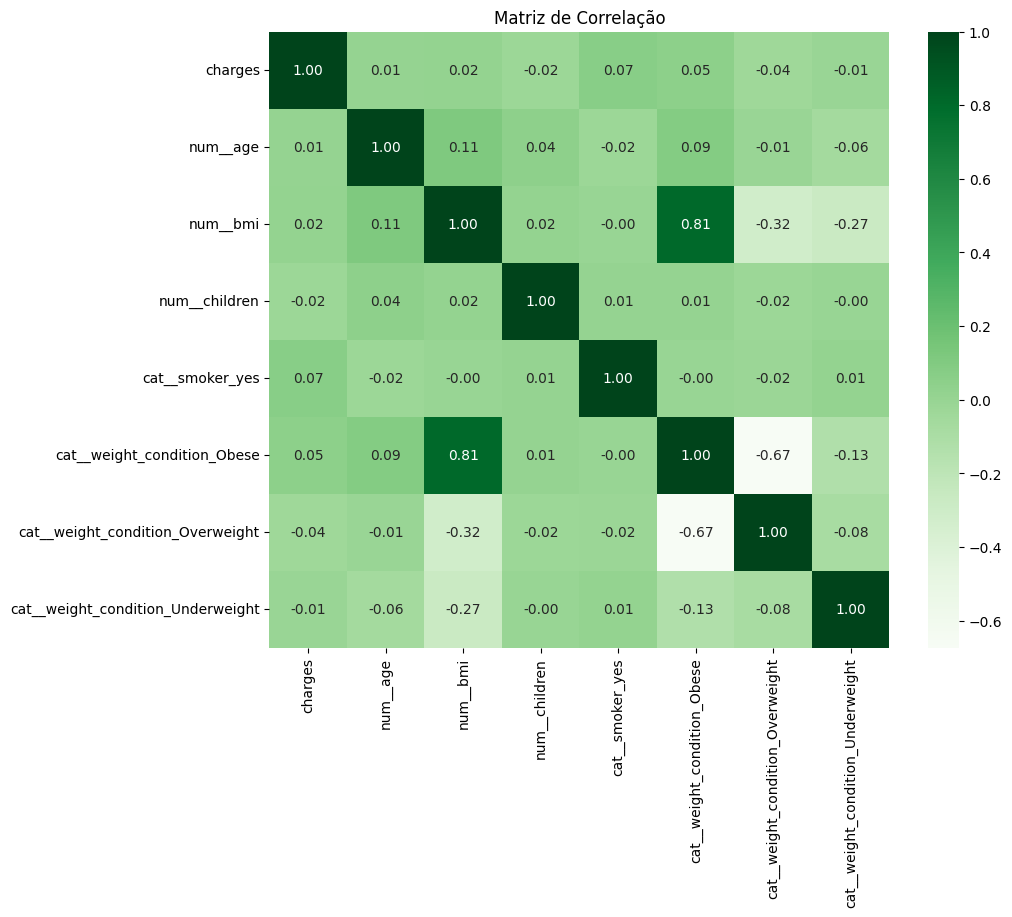

In [518]:
# Matriz de correlação
correlation_matrix = data.corr()
print(correlation_matrix["charges"].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [519]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train

,num__age,num__bmi,num__children,cat__smoker_yes,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
625,0.341540,1.421604,-0.907940,1.0,1.0,0.0,0.0
195,-0.014521,0.382352,-0.907940,0.0,1.0,0.0,0.0
241,1.124873,-0.631552,-0.079764,0.0,0.0,1.0,0.0
1176,-1.153915,-0.345969,-0.079764,1.0,0.0,1.0,0.0
1200,-0.156945,-0.841937,-0.079764,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
767,0.982449,-0.648450,0.748411,0.0,0.0,1.0,0.0
839,1.267298,-0.122910,-0.907940,1.0,0.0,1.0,0.0
1224,1.053661,-1.002472,1.576587,0.0,0.0,0.0,0.0
563,0.127903,0.008897,0.748411,0.0,1.0,0.0,0.0


In [520]:
# Remove rows with NaN values from train and test sets
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]
X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]

models = [
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=200, 
                          max_depth=18, max_leaf_nodes=12,
                          criterion = 'friedman_mse',
                          random_state = 1,
                          n_jobs = -1),
    KNeighborsRegressor(n_neighbors=20)
]
for model in models:
    plot_chart_and_predict(model, X_test_clean, X_train_clean, y_test_clean, y_train_clean)

ValueError: Input y contains NaN.

Modelo:  RandomForestRegressor(criterion='friedman_mse', max_depth=20, max_leaf_nodes=17,
                      n_estimators=7, random_state=1)
Mean Squared Error (MSE):  147520402.29237577
Mean Absolute Error (MAE):  9226.48527009722
O MAPE é: 141.67%
R-squared (R2):  -0.03461551435212895


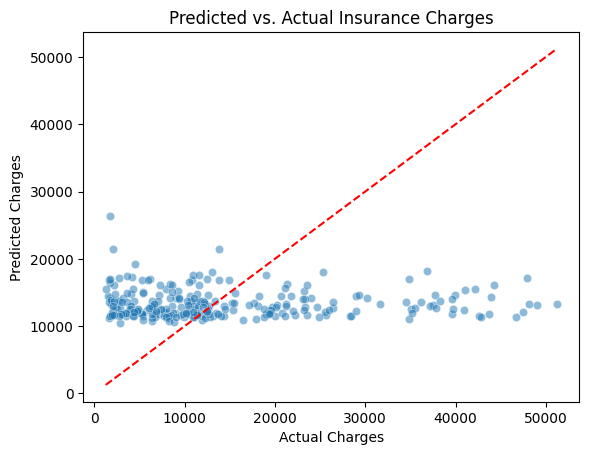

-------------------
Modelo:  KNeighborsRegressor(n_neighbors=25)
Mean Squared Error (MSE):  147020203.3814697
Mean Absolute Error (MAE):  9181.877035959551
O MAPE é: 135.53%
R-squared (R2):  -0.031107433127812723


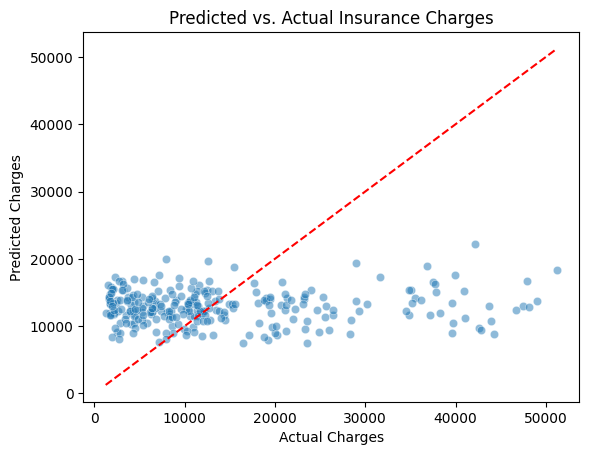

-------------------


In [ ]:
# Selecionando alguns modelos e verificando o desempenho
models = [
    RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1),
    KNeighborsRegressor(n_neighbors=25)
]

# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape_result = calculate_mape(y_test, y_pred)
    
    print("Modelo: ", model)
    print('Mean Squared Error (MSE): ', mse)
    print('Mean Absolute Error (MAE): ', mae)
    print(f"O MAPE é: {mape_result:.2f}%")
    print('R-squared (R2): ', r2)
    
    # Criando um DataFrame para armazenar os valores reais e previstos
    
    results = pd.DataFrame({
        "Actual Charges": y_test,
        "Predicted Charges": y_pred
    })
    
    sns.scatterplot(data=results, x="Actual Charges", y="Predicted Charges", alpha=0.5)
    plt.plot(
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        color='red',
        linestyle='--'
    )
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted vs. Actual Insurance Charges")
    plt.show()
    print('-------------------')
    
